<a href="https://colab.research.google.com/github/thunder913/Deep-Learning/blob/main/stocks_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import kagglehub
import numpy as np
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import pickle
import pdb
import tensorflow as tf
import keras
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Concatenate, BatchNormalization, AdditiveAttention, Multiply, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Stocks LSTM Prediction

In [427]:
google_drive_path = 'drive/MyDrive/DL_Pickles/'

path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

stock_prices_path = f"{path}/stocks_latest/stock_prices_latest.csv"

stock_data_path = f"./{google_drive_path}/stock_data_processed.pkl"
scaler_path = f"./{google_drive_path}/scalers.pkl"

In [4]:
def calculate_rsi(group, period = 14):
    delta = group['close_adjusted'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / np.where(avg_loss != 0, avg_loss, 1)

    group['RSI'] = 100 - (100 / (1 + rs))

    return group

def calculate_macd(group, short_window=12, long_window=26, signal_window=9):
    # Calculate EMA short and long
    ema_short = group['close_adjusted'].ewm(span=short_window, adjust=False).mean()
    ema_long = group['close_adjusted'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD and Signal Line
    group['MACD'] = ema_short - ema_long
    group['Signal_Line'] = group['MACD'].ewm(span=signal_window, adjust=False).mean()

    return group

In [5]:
def get_peak_price_and_days_ago(df):
    """
    Calculate the peak price over a rolling 90-day window and determine the number of days
    since the peak price for each row in the DataFrame.
    """

    #df['peak_price'] = df['close'].rolling(window=90, min_periods=1).max()
    #peak_day_index = df['close'].rolling(window=90, min_periods=1).apply(lambda x: (len(x) - 1 - x.argmax()), raw=False)
    #df['peak_days_ago'] = peak_day_index.fillna(0).astype(int)  # Fill NaN for rows that don't have enough data
    return df

def process_ticker_data(df):
    """
    Add historical price features for specific days ago for each stock (grouped by ticker).
    Also calculate the peak price and days since the peak price for each stock.
    """

    print('Calculated RSI')
    # Calculate RSI (14-day by default)
    df = df.groupby('ticker', group_keys=False).apply(calculate_rsi)

    print('Calculated moving averages')
    # Add moving averages
    moving_average_windows = [5, 10, 20, 50, 100, 200]  # Specify moving average windows
    for window in moving_average_windows:
        df[f'{window}_day_MA'] = df.groupby('ticker')['close_adjusted'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)

    print('Calculated MACD')
    # Calculate MACD and Signal Line

    df = df.groupby('ticker', group_keys=False).apply(calculate_macd)

    print('Calculated price days ago')
    # Add columns for prices X days ago
    for days in [1,2,3,4,5, 10, 15, 30, 60, 90]:
        df[f'price_{days}_days_ago'] = df.groupby('ticker')['close_adjusted'].shift(days)

    df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)

    # Remove the first 200 rows for each ticker
    df = df.groupby('ticker').apply(lambda group: group.iloc[200:]).reset_index(drop=True)

    return df

In [6]:
def getTidiedStockData():
    """
    Read and tidy the stock data dataset. If the processed stock data already exists as a pickle file,
    it loads and returns the data. Otherwise, it processes the raw stock data, cleans it, adds features,
    and saves the tidy data to a pickle file for future use.
    """

    # Check if the file exists
    if os.path.exists(stock_data_path):
        print('found pickle')
        return pd.read_pickle(stock_data_path)

    # Read the basic data and some tidying
    stock_data = pd.read_csv(stock_prices_path)
    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)

    # Encode labels
    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])

    stock_data_tidy.to_pickle(stock_data_path)

    return stock_data_tidy

In [374]:
stock_data_tidy = getTidiedStockData()

found pickle


In [375]:
stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close', 'volume'])

In [376]:
stock_data_tidy['day_of_week'] = stock_data_tidy['date'].dt.dayofweek

In [332]:
def plot_stock_chart(stock_data_tidy, ticker, start_date=None, end_date=None):
    """
    Plot a stock chart for a specific ticker.

    Parameters:
        stock_data_tidy (DataFrame): The DataFrame containing stock data.
        ticker (str): The ticker to plot.
        start_date (str): Optional start date (e.g., '2023-01-01').
        end_date (str): Optional end date (e.g., '2023-12-31').
    """
    # Filter data for the specific ticker and date range
    stock_data_tidy['date'] = pd.to_datetime(stock_data_tidy['date'])
    filtered_data = stock_data_tidy[stock_data_tidy['ticker'] == ticker]

    if start_date:
        filtered_data = filtered_data[filtered_data['date'] >= start_date]
    if end_date:
        filtered_data = filtered_data[filtered_data['date'] <= end_date]

    # Ensure data is sorted by date
    filtered_data = filtered_data.sort_values(by='date')

    # Plot the stock chart
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['date'], filtered_data['close_adjusted'], label='Close Price', color='blue', linewidth=2)

    # Add moving averages if they exist in the DataFrame
    for col in ['5_day_MA', '10_day_MA', '50_day_MA']:
        if col in filtered_data.columns:
            plt.plot(filtered_data['date'], filtered_data[col], label=col, linestyle='--')

    # Chart settings
    plt.title(f"Stock Chart for {ticker}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

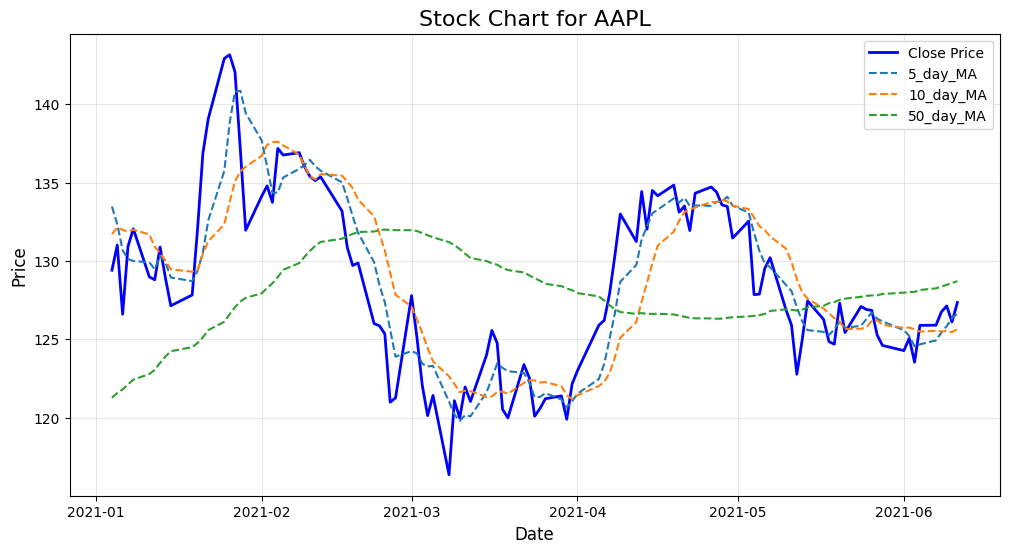

In [377]:
plot_stock_chart(stock_data_tidy, ticker='AAPL', start_date='2021-01-01', end_date='2022-12-31')

In [378]:
stock_data_tidy.columns

Index(['ticker', 'date', 'close_adjusted', 'RSI', '5_day_MA', '10_day_MA',
       '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA', 'MACD',
       'Signal_Line', 'price_1_days_ago', 'price_2_days_ago',
       'price_3_days_ago', 'price_4_days_ago', 'price_5_days_ago',
       'price_10_days_ago', 'price_15_days_ago', 'price_30_days_ago',
       'price_60_days_ago', 'price_90_days_ago', 'ticker_encoded',
       'day_of_week'],
      dtype='object')

In [379]:
# TODO if needed remove big values, since they are mostly outliers
# tickers_to_remove = stock_data_tidy[stock_data_tidy['close_adjusted'] > 10000]['ticker'].unique()

# stock_data_tidy = stock_data_tidy[~stock_data_tidy['ticker'].isin(tickers_to_remove)]

In [380]:
stock_data_tidy = stock_data_tidy.drop(columns=['price_1_days_ago', 'price_2_days_ago',
    'price_3_days_ago', 'price_4_days_ago', 'price_5_days_ago',
    'price_10_days_ago', 'price_15_days_ago', 'price_30_days_ago',
    'price_60_days_ago', 'price_90_days_ago'])

In [426]:
# TODO if all works with scalers for every ticker, remove this

# numerical_columns = [
#     'close_adjusted', 'RSI', '5_day_MA', '10_day_MA',
#     '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA',
#     'MACD', 'Signal_Line'
# ]


# scaler = MinMaxScaler()

# stock_data_tidy[numerical_columns] = scaler.fit_transform(stock_data_tidy[numerical_columns])

# numerical_columns.extend(['day_of_week', 'ticker_encoded'])

In [381]:
numerical_columns = [
    'close_adjusted', 'RSI', '5_day_MA', '10_day_MA',
    '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA',
    'MACD', 'Signal_Line'
]


if os.path.exists(scaler_path):
    # Load previously saved scalers
    with open(scaler_path, "rb") as f:
        scalers = pickle.load(f)
    print("Loaded existing scalers from file.")
else:
    scalers = {}  # Dictionary to store scalers per ticker

    for ticker in stock_data_tidy['ticker'].unique():
        scaler = MinMaxScaler()
        
        # Select only the rows for this specific ticker
        ticker_mask = stock_data_tidy['ticker'] == ticker
        
        # Fit the scaler on the numerical columns for this ticker
        scalers[ticker] = scaler.fit(stock_data_tidy.loc[ticker_mask, numerical_columns])
        
        # Transform and assign back directly
        stock_data_tidy.loc[ticker_mask, numerical_columns] = scaler.transform(stock_data_tidy.loc[ticker_mask, numerical_columns])
    
    # Save the trained scalers to a file
    with open(scaler_path, "wb") as f:
        pickle.dump(scalers, f)
    print("Saved new scalers to file.")


numerical_columns.extend(['day_of_week', 'ticker_encoded'])

A
AA
AAAP
AABA
AAC
AACG
AACQU
AAL
AAMC
AAME
AAN
AAOI
AAON
AAP
AAPL
AAT
AAU
AAV
AAWW
AAXJ
AAXN
AB
ABAC
ABAX
ABB
ABBV
ABC
ABCB
ABCD
ABDC
ABE
ABEO
ABEOW
ABEV
ABG
ABIL
ABM
ABMD
ABR
ABRN
ABT
ABTX
ABUS
ABX
AC
ACA
ACAD
ACAMU
ACAMW
ACB
ACBI
ACC
ACCD
ACCO
ACER
ACERW
ACET
ACEVU
ACFC
ACGL
ACGLO
ACGLP
ACH
ACHC
ACHN
ACHV
ACIA
ACIU
ACIW
ACLS
ACM
ACMR
ACN
ACNB
ACOR


KeyboardInterrupt: 

In [384]:
unique_count = stock_data_tidy['ticker'].nunique()

In [385]:
def preprocess_data(stock_data_tidy, numerical_columns, sequence_length):
    data = stock_data_tidy[numerical_columns].values

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i])
        y.append(data[i, 0])

    X = np.array(X)
    y = np.array(y)

    return X, y

In [386]:
def create_lstm_model(sequence_length, num_features, lstm_units_1=50, lstm_units_2=50, dropout_rate=0.1):
    """
    Optimized LSTM model for stock price prediction with Additive Attention.
    """
    numerical_input = Input(shape=(sequence_length, num_features), name="numerical_input")

    first_lstm_layer = LSTM(lstm_units_1, return_sequences=True, name="lstm_layer_1", dropout=dropout_rate)(numerical_input)
    x = BatchNormalization()(first_lstm_layer)

    second_lstm_layer = LSTM(lstm_units_2, return_sequences=True, name="lstm_layer_2", dropout=dropout_rate)(first_lstm_layer)
    x = BatchNormalization()(second_lstm_layer)

    # Attention mechanism
    attention = AdditiveAttention(name="attention_layer")([second_lstm_layer, second_lstm_layer])
    attended = Multiply()([second_lstm_layer, attention])

    flat = Flatten()(attended)

    x = Dense(64, activation='relu', name="dense_1")(flat)

    output = Dense(32, activation='relu', name="dense_2")(x)

    output = Dense(1, activation='linear', name="output")(output)

    model = Model(inputs=numerical_input, outputs=output, name="Optimized_LSTM_Model_with_Attention")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [387]:
lstm_model = create_lstm_model(sequence_length=30, num_features=len(numerical_columns))

In [388]:
lstm_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 30, 50)    │     12,200 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_2 (LSTM) │ (None, 30, 50)    │     20,200 │ lstm_layer_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 30, 50)    │         50 │ lstm_layer_2[0][… │
│ (AdditiveAttention) │                   │            │ lstm_layer_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_11         │ (None, 30, 50)    │          0 │ lstm_layer_2[0][… │
│ (Multiply)          │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 1500)      │          0 │ multiply_11[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     96,064 │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 130,627 (510.26 KB)

 Trainable params: 130,627 (510.26 KB)

 Non-trainable params: 0 (0.00 B)

In [389]:
stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'])

In [428]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

processed_data_path = google_drive_path + 'processed_data_with_before_prices/'

def preprocess_grouped_data(stock_data_tidy, numerical_columns, target_column, sequence_length):
    tickers = stock_data_tidy["ticker_encoded"].unique()

    for ticker in tickers:
        ticker_data = stock_data_tidy[stock_data_tidy["ticker_encoded"] == ticker].sort_values(by="date")
        numerical_data = ticker_data[numerical_columns].values

        if(ticker % 1000 == 0):
          print('Processing ', ticker)
        if len(ticker_data) > sequence_length:
            x_ticker = sliding_window_view(numerical_data, window_shape=(sequence_length, len(numerical_columns)))
            x_ticker = x_ticker.reshape(-1, sequence_length, len(numerical_columns))

            y_ticker = ticker_data[target_column].values[sequence_length-1:]

            np.save(os.path.join(processed_data_path, f"x_ticker_{ticker}.npy"), x_ticker)
            np.save(os.path.join(processed_data_path, f"y_ticker_{ticker}.npy"), y_ticker)

In [391]:
if os.path.exists(processed_data_path) and os.path.isdir(processed_data_path):
    has_file = any(os.path.isfile(os.path.join(processed_data_path, item)) for item in os.listdir(processed_data_path))
    if has_file:
        print("There are files in the processed_data_path.")
    else:
      print('Beginning to process the data...\n')
      preprocess_grouped_data(stock_data_tidy, numerical_columns, 'close_adjusted', 30)
else:
    print("The processed_data_path does not exist or is not a directory.")

Beginning to process the data...

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Processing  0


In [402]:
x_files = [f for f in os.listdir(processed_data_path) if f.startswith("x_ticker_")]
tickers = [f.split("_")[-1].replace(".npy", "") for f in x_files]
batch_size = 32

def data_generator(tickers, processed_data_path):
    """Yields data for one ticker per epoch."""
    tickers = [14]

    while True:
        for ticker in tickers:
            returned_count = 0
            # Load data for the current ticker
            x_path = os.path.join(processed_data_path, f"x_ticker_{ticker}.npy")
            y_path = os.path.join(processed_data_path, f"y_ticker_{ticker}.npy")

            x_data = np.load(x_path)
            y_data = np.load(y_path)

            # Ensure data is compatible with the batch size
            steps_per_epoch = len(x_data) // batch_size
            x_data = x_data[:steps_per_epoch * batch_size]
            y_data = y_data[:steps_per_epoch * batch_size]

            # Reshape and yield in batches
            for i in range(steps_per_epoch):
                x_batch = x_data[i * batch_size: (i + 1) * batch_size]
                y_batch = y_data[i * batch_size: (i + 1) * batch_size]
                returned_count += len(x_batch)
                yield x_batch, y_batch

In [393]:
tickers.sort()

In [403]:
train_gen = data_generator(tickers, processed_data_path)

In [395]:
early_stopping = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

In [404]:
keras.backend.clear_session()

In [405]:
lstm_model.fit(
    train_gen,
    steps_per_epoch=200,
    epochs=50,
    callbacks=[early_stopping]
)

print("Training complete!")



Ticker:  14
Epoch 1/50
172/200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0054 - mae: 0.0607
176/200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0054 - mae: 0.0604 14
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0054 - mae: 0.0593
Epoch 2/50
151/200 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.7985e-04 - mae: 0.0137
Ticker:  14
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0015 - mae: 0.0192
Epoch 3/50
128/200 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9998e-04 - mae: 0.0113
Ticker:  14
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0019 - mae: 0.0192
Epoch 4/50
104/200 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - mae: 0.0279
Ticker:  14
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0037 - mae: 0.0386
Epoch 5/50
 81/200 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019 - mae: 0.0358
Ticker:  14
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0050 - mae: 0.0494
Epoch 6/50
 60/200 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0021 - mae: 0.0346
Ticker:  1

In [147]:
lstm_model.save(google_drive_path + 'lstm_model3_3.keras')

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/DL_Pickles/lstm_model3_2.keras'

In [421]:
aapl_data = stock_data_tidy[stock_data_tidy.ticker == "AAPL"]

X = aapl_data[numerical_columns].values
y = aapl_data['close_adjusted'].values

sequence_length = 30  # Assume sequence length
num_features = X.shape[1]

X_sequences = []
y_sequences = []

for i in range(sequence_length, len(X)):
    X_sequences.append(X[i-sequence_length:i])
    y_sequences.append(y[i])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [422]:
y_pred = lstm_model.predict(X_sequences)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [423]:
def inverse_transform_predictions(y_pred, ticker):
    num_features = X_sequences.shape[2]
    
    # Use the correct scaler for this ticker
    scaler = scalers[ticker]
    
    # Inverse transform only the first column (close_adjusted)
    y_pred_rescaled = scaler.inverse_transform(
        np.concatenate((y_pred.reshape(-1,1), np.zeros((len(y_pred), num_features - 1))), axis=1)
    )[:,0]
    
    return y_pred_rescaled

In [424]:
y_sequence_rescaled = inverse_transform_predictions(y_sequences, 'AAPL')
y_pred_rescaled = inverse_transform_predictions(y_pred, 'AAPL')

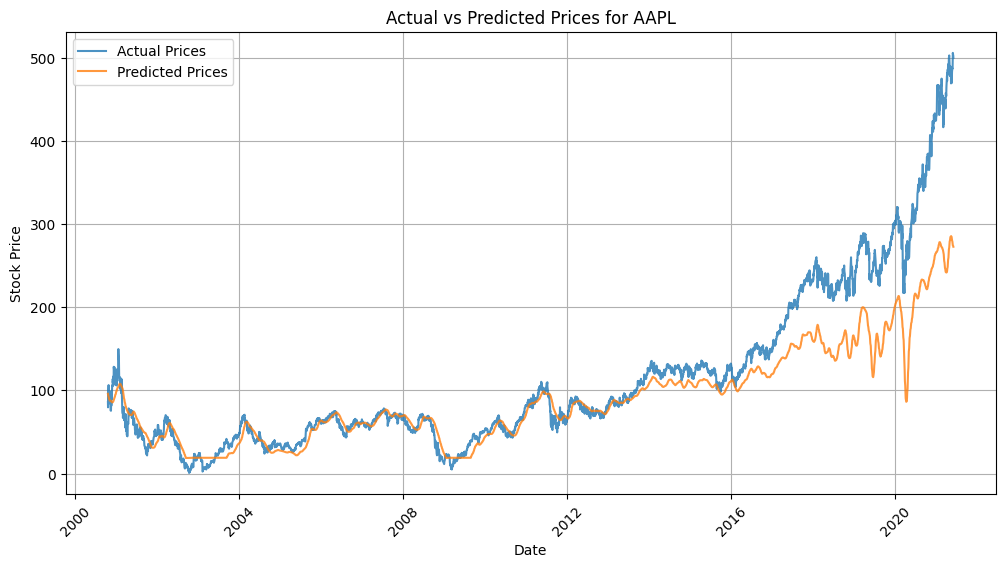

In [425]:
plt.figure(figsize=(12, 6))

# Slice the date column to match the predictions
dates = aapl_data['date'].iloc[sequence_length:].reset_index(drop=True)

plt.plot(dates, y_sequence_rescaled, label='Actual Prices', alpha=0.8)
plt.plot(dates, y_pred_rescaled, label='Predicted Prices', alpha=0.8)

plt.title('Actual vs Predicted Prices for AAPL')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()
